# 3D ResNet Fine-tuning for AD vs CN Classification

This notebook fine-tunes a simple 3D ResNet network to classify Alzheimer's Disease (AD) vs Control Normal (CN) using MRI volumes.

## 1. Imports and Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict

# Add current directory to path to import local modules
sys.path.insert(0, '/home/tianze/Code/VideoMAE')

from kinetics import VideoClsDataset
from datasets import build_dataset
import argparse

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

/home/tianze/anaconda3/envs/videomae/lib/python3.10/site-packages/torch/cuda/__init__.py:51: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda


## 2. Define Simple 3D ResNet Model

In [2]:
class BasicBlock3D(nn.Module):
    """3D Basic ResNet Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet3D(nn.Module):
    """Simple 3D ResNet for video/volume classification"""
    
    def __init__(self, block, layers, num_classes=2, in_channels=3):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        
        # Initial conv layer
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Input shape: (B, C, T, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet3d_18(num_classes=2, in_channels=3):
    """Constructs a ResNet3D-18 model."""
    return ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes, in_channels=in_channels)


def resnet3d_34(num_classes=2, in_channels=3):
    """Constructs a ResNet3D-34 model."""
    return ResNet3D(BasicBlock3D, [3, 4, 6, 3], num_classes=num_classes, in_channels=in_channels)


# Create model
model = resnet3d_18(num_classes=2, in_channels=3)
model = model.to(device)
print(f'Model created. Total parameters: {sum(p.numel() for p in model.parameters()):,}')

Model created. Total parameters: 33,167,298


## 3. Configuration

In [3]:
# Configuration
config = {
    'data_path': '/home/tianze/DATA_2T/MRI/csv_for_finetuning/Finalized_all/Downstreamtask_csv',  # Update this path
    # 'ood_data_path': '/home/tianze/DATA_2T/MRI/csv_for_finetuning/ad_cn',  # Path to OOD dataset (OASIS3_final.csv should be here)
    'test_ood': False,  # Set to True to test on OOD dataset
    'batch_size': 16,
    'num_workers': 10,
    'num_frames': 16,
    'sampling_rate': 4,
    'input_size': 224,
    'short_side_size': 224,
    'num_classes': 2,
    'epochs': 50,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'save_dir': './checkpoints/resnet3d_mci_cn',
    'resume': None,  # Path to checkpoint to resume from
}

# Create save directory
os.makedirs(config['save_dir'], exist_ok=True)

print('Configuration:')
for k, v in config.items():
    print(f'  {k}: {v}')

Configuration:
  data_path: /home/tianze/DATA_2T/MRI/csv_for_finetuning/Finalized_all/Downstreamtask_csv
  test_ood: False
  batch_size: 16
  num_workers: 10
  num_frames: 16
  sampling_rate: 4
  input_size: 224
  short_side_size: 224
  num_classes: 2
  epochs: 50
  lr: 0.001
  weight_decay: 0.0001
  save_dir: ./checkpoints/resnet3d_mci_cn
  resume: None


## 4. Create Dataset and DataLoaders

In [4]:
# Create a simple args object for dataset
class Args:
    def __init__(self):
        self.data_set = 'MCI_CN'
        self.data_path = config['data_path']
        self.nb_classes = config['num_classes']
        self.num_frames = config['num_frames']
        self.sampling_rate = config['sampling_rate']
        self.input_size = config['input_size']
        self.short_side_size = config['short_side_size']
        self.test_num_segment = 5
        self.test_num_crop = 3
        self.reprob = 0.0  # Random erase probability
        self.aa = None  # AutoAugment
        self.smoothing = 0.0  # Label smoothing

args = Args()

# Build datasets
print('Loading datasets...')
dataset_train, _ = build_dataset(is_train=True, test_mode=False, args=args)
dataset_val, _ = build_dataset(is_train=False, test_mode=False, args=args)
dataset_test, _ = build_dataset(is_train=False, test_mode=True, args=args)

print(f'Train samples: {len(dataset_train)}')
print(f'Val samples: {len(dataset_val)}')
print(f'Test samples: {len(dataset_test)}')

# Create data loaders
train_loader = DataLoader(
    dataset_train,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    dataset_val,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=False
)

test_loader = DataLoader(
    dataset_test,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=False
)

print('Data loaders created successfully!')

Loading datasets...
Dataset initialized with 1414 samples for mode: train
Number of the class = 2
Dataset initialized with 263 samples for mode: validation
Number of the class = 2
Dataset initialized with 292 samples for mode: test
Number of the class = 2
Train samples: 1414
Val samples: 263
Test samples: 292
Data loaders created successfully!


## 5. Training Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
    
    for batch_idx, (videos, labels, _, _) in enumerate(pbar):
        # Move to device
        videos = videos.to(device)  # Shape: (B, C, T, H, W)
        labels = labels.to(device).long()
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device, split='Val'):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'[{split}]')
        for videos, labels, _ in pbar:
            videos = videos.to(device)
            labels = labels.to(device).long()
            
            outputs = model(videos)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Collect for AUROC
            probs = torch.softmax(outputs, dim=1)
            all_outputs.append(probs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    # Calculate AUROC and F1 score
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate predictions for F1 score
    all_preds = np.argmax(all_outputs, axis=1)
    
    try:
        auroc = roc_auc_score(all_targets, all_outputs[:, 1])
    except ValueError:
        auroc = 0.0
    
    try:
        f1 = f1_score(all_targets, all_preds, average='binary')
    except ValueError:
        f1 = 0.0
    
    return epoch_loss, epoch_acc, auroc, f1

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],
    eta_min=1e-6
)

print('Optimizer and scheduler created')

Optimizer and scheduler created


## 7. Training Loop

In [7]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_auroc': [],
    'val_f1': [],
    'lr': []
}

# Resume from checkpoint if specified
start_epoch = 0
best_val_acc = 0.0
best_val_auroc = 0.0
best_val_f1 = 0.0

if config['resume'] and os.path.exists(config['resume']):
    print(f'Loading checkpoint from {config["resume"]}')
    checkpoint = torch.load(config['resume'], map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    best_val_auroc = checkpoint.get('best_val_auroc', 0.0)
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    history = checkpoint.get('history', history)
    print(f'Resumed from epoch {start_epoch}')

print('Starting training...')
print('=' * 80)

for epoch in range(start_epoch, config['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validate
    val_loss, val_acc, val_auroc, val_f1 = validate(model, val_loader, criterion, device, 'Val')
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auroc'].append(val_auroc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{config["epochs"]}:')
    print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
    print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}')
    print(f'  LR: {current_lr:.6f}')
    print('-' * 80)
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'best_val_auroc': best_val_auroc,
        'best_val_f1': best_val_f1,
        'history': history
    }
    
    # Save latest checkpoint
    torch.save(checkpoint, os.path.join(config['save_dir'], 'checkpoint_latest.pth'))
    
    # Save best checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_auroc = val_auroc
        best_val_f1 = val_f1
        checkpoint['best_val_acc'] = best_val_acc
        checkpoint['best_val_auroc'] = best_val_auroc
        checkpoint['best_val_f1'] = best_val_f1
        torch.save(checkpoint, os.path.join(config['save_dir'], 'checkpoint_best.pth'))
        print(f'  *** New best model saved! (Acc: {best_val_acc:.2f}%, AUROC: {best_val_auroc:.4f}, F1: {best_val_f1:.4f}) ***')

print('=' * 80)
print('Training completed!')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Corresponding AUROC: {best_val_auroc:.4f}')
print(f'Corresponding F1 Score: {best_val_f1:.4f}')

Starting training...


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, loss=0.3884, acc=65.40%]


Epoch 1/50:
  Train - Loss: 0.6786, Acc: 66.48%
  Val   - Loss: 0.6096, Acc: 65.40%, AUROC: 0.6322, F1: 0.0000
  LR: 0.000999
--------------------------------------------------------------------------------
  *** New best model saved! (Acc: 65.40%, AUROC: 0.6322) ***


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s, loss=0.6959, acc=63.50%]


Epoch 2/50:
  Train - Loss: 0.5966, Acc: 69.60%
  Val   - Loss: 0.6523, Acc: 63.50%, AUROC: 0.8180, F1: 0.5932
  LR: 0.000996
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s, loss=0.5351, acc=68.82%]


Epoch 3/50:
  Train - Loss: 0.5744, Acc: 70.88%
  Val   - Loss: 0.6146, Acc: 68.82%, AUROC: 0.7957, F1: 0.6339
  LR: 0.000991
--------------------------------------------------------------------------------
  *** New best model saved! (Acc: 68.82%, AUROC: 0.7957) ***


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.16it/s, loss=0.9013, acc=52.47%]


Epoch 4/50:
  Train - Loss: 0.5331, Acc: 73.72%
  Val   - Loss: 0.8676, Acc: 52.47%, AUROC: 0.8479, F1: 0.5645
  LR: 0.000984
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s, loss=0.3483, acc=77.19%]


Epoch 5/50:
  Train - Loss: 0.4781, Acc: 77.91%
  Val   - Loss: 0.4818, Acc: 77.19%, AUROC: 0.8036, F1: 0.5000
  LR: 0.000976
--------------------------------------------------------------------------------
  *** New best model saved! (Acc: 77.19%, AUROC: 0.8036) ***


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.34it/s, loss=0.5946, acc=66.54%]


Epoch 6/50:
  Train - Loss: 0.3917, Acc: 82.03%
  Val   - Loss: 0.7236, Acc: 66.54%, AUROC: 0.7912, F1: 0.6036
  LR: 0.000965
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s, loss=0.0211, acc=76.05%]


Epoch 7/50:
  Train - Loss: 0.2950, Acc: 88.71%
  Val   - Loss: 0.8145, Acc: 76.05%, AUROC: 0.7667, F1: 0.4960
  LR: 0.000952
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:20<00:00,  1.22s/it, loss=0.2187, acc=68.06%]


Epoch 8/50:
  Train - Loss: 0.2250, Acc: 91.05%
  Val   - Loss: 0.7222, Acc: 68.06%, AUROC: 0.7185, F1: 0.5172
  LR: 0.000938
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s, loss=0.0272, acc=76.81%]


Epoch 9/50:
  Train - Loss: 0.1871, Acc: 93.32%
  Val   - Loss: 0.6818, Acc: 76.81%, AUROC: 0.7974, F1: 0.5344
  LR: 0.000922
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, loss=0.0009, acc=70.72%]


Epoch 10/50:
  Train - Loss: 0.1578, Acc: 93.96%
  Val   - Loss: 1.4175, Acc: 70.72%, AUROC: 0.8512, F1: 0.1538
  LR: 0.000905
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s, loss=0.0047, acc=68.82%]


Epoch 11/50:
  Train - Loss: 0.1156, Acc: 95.74%
  Val   - Loss: 1.1732, Acc: 68.82%, AUROC: 0.8146, F1: 0.0465
  LR: 0.000885
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.10it/s, loss=0.4293, acc=76.81%]


Epoch 12/50:
  Train - Loss: 0.0609, Acc: 98.08%
  Val   - Loss: 0.7090, Acc: 76.81%, AUROC: 0.8197, F1: 0.6115
  LR: 0.000865
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s, loss=0.5641, acc=72.24%]


Epoch 13/50:
  Train - Loss: 0.0249, Acc: 99.22%
  Val   - Loss: 0.8599, Acc: 72.24%, AUROC: 0.7948, F1: 0.5876
  LR: 0.000842
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s, loss=0.8135, acc=70.34%]


Epoch 14/50:
  Train - Loss: 0.0763, Acc: 97.23%
  Val   - Loss: 0.8482, Acc: 70.34%, AUROC: 0.7774, F1: 0.5517
  LR: 0.000819
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s, loss=0.1254, acc=73.76%]


Epoch 15/50:
  Train - Loss: 0.0628, Acc: 97.80%
  Val   - Loss: 0.8546, Acc: 73.76%, AUROC: 0.7761, F1: 0.4733
  LR: 0.000794
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s, loss=1.8642, acc=63.50%]


Epoch 16/50:
  Train - Loss: 0.0370, Acc: 98.44%
  Val   - Loss: 1.5429, Acc: 63.50%, AUROC: 0.7538, F1: 0.5826
  LR: 0.000768
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s, loss=0.0299, acc=68.44%]


Epoch 17/50:
  Train - Loss: 0.0337, Acc: 99.22%
  Val   - Loss: 1.0422, Acc: 68.44%, AUROC: 0.7504, F1: 0.4354
  LR: 0.000741
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s, loss=0.0332, acc=73.38%]


Epoch 18/50:
  Train - Loss: 0.0156, Acc: 99.50%
  Val   - Loss: 1.7487, Acc: 73.38%, AUROC: 0.7932, F1: 0.3636
  LR: 0.000713
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s, loss=0.2653, acc=74.90%]


Epoch 19/50:
  Train - Loss: 0.0281, Acc: 98.93%
  Val   - Loss: 1.0521, Acc: 74.90%, AUROC: 0.8099, F1: 0.4590
  LR: 0.000684
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.15it/s, loss=0.5100, acc=72.24%]


Epoch 20/50:
  Train - Loss: 0.0076, Acc: 99.79%
  Val   - Loss: 1.2565, Acc: 72.24%, AUROC: 0.7881, F1: 0.4252
  LR: 0.000655
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s, loss=0.3672, acc=77.95%]


Epoch 21/50:
  Train - Loss: 0.0098, Acc: 99.79%
  Val   - Loss: 0.9208, Acc: 77.95%, AUROC: 0.8276, F1: 0.5857
  LR: 0.000625
--------------------------------------------------------------------------------
  *** New best model saved! (Acc: 77.95%, AUROC: 0.8276) ***


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.16it/s, loss=3.1125, acc=59.70%]


Epoch 22/50:
  Train - Loss: 0.0237, Acc: 99.36%
  Val   - Loss: 2.2775, Acc: 59.70%, AUROC: 0.7986, F1: 0.5923
  LR: 0.000594
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s, loss=0.2654, acc=70.34%]


Epoch 23/50:
  Train - Loss: 0.0329, Acc: 98.72%
  Val   - Loss: 1.1455, Acc: 70.34%, AUROC: 0.7619, F1: 0.4868
  LR: 0.000563
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s, loss=0.1781, acc=71.48%]


Epoch 24/50:
  Train - Loss: 0.0139, Acc: 99.72%
  Val   - Loss: 1.3402, Acc: 71.48%, AUROC: 0.7497, F1: 0.4275
  LR: 0.000532
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s, loss=0.2992, acc=69.58%]


Epoch 25/50:
  Train - Loss: 0.0140, Acc: 99.43%
  Val   - Loss: 1.2596, Acc: 69.58%, AUROC: 0.7425, F1: 0.4203
  LR: 0.000500
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s, loss=0.0064, acc=71.10%]


Epoch 26/50:
  Train - Loss: 0.0168, Acc: 99.22%
  Val   - Loss: 1.9807, Acc: 71.10%, AUROC: 0.7574, F1: 0.3214
  LR: 0.000469
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s, loss=0.2347, acc=71.10%]


Epoch 27/50:
  Train - Loss: 0.0051, Acc: 99.86%
  Val   - Loss: 1.6265, Acc: 71.10%, AUROC: 0.7390, F1: 0.5065
  LR: 0.000438
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s, loss=0.3629, acc=68.82%]


Epoch 28/50:
  Train - Loss: 0.0054, Acc: 99.86%
  Val   - Loss: 1.4534, Acc: 68.82%, AUROC: 0.7475, F1: 0.4459
  LR: 0.000407
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s, loss=0.8467, acc=63.88%]


Epoch 29/50:
  Train - Loss: 0.0067, Acc: 99.72%
  Val   - Loss: 1.4967, Acc: 63.88%, AUROC: 0.7177, F1: 0.4974
  LR: 0.000376
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s, loss=0.0692, acc=73.76%]


Epoch 30/50:
  Train - Loss: 0.0027, Acc: 100.00%
  Val   - Loss: 1.5463, Acc: 73.76%, AUROC: 0.7430, F1: 0.4733
  LR: 0.000346
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s, loss=0.4438, acc=72.62%]


Epoch 31/50:
  Train - Loss: 0.0044, Acc: 99.86%
  Val   - Loss: 1.1801, Acc: 72.62%, AUROC: 0.7687, F1: 0.5135
  LR: 0.000317
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s, loss=0.2458, acc=73.76%]


Epoch 32/50:
  Train - Loss: 0.0024, Acc: 99.93%
  Val   - Loss: 1.2545, Acc: 73.76%, AUROC: 0.7767, F1: 0.5106
  LR: 0.000288
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s, loss=0.0395, acc=70.34%]


Epoch 33/50:
  Train - Loss: 0.0041, Acc: 99.93%
  Val   - Loss: 1.3534, Acc: 70.34%, AUROC: 0.7538, F1: 0.4800
  LR: 0.000260
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.25it/s, loss=0.1558, acc=69.58%]


Epoch 34/50:
  Train - Loss: 0.0007, Acc: 100.00%
  Val   - Loss: 1.4219, Acc: 69.58%, AUROC: 0.7464, F1: 0.4805
  LR: 0.000233
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.34it/s, loss=0.8261, acc=68.44%]


Epoch 35/50:
  Train - Loss: 0.0036, Acc: 100.00%
  Val   - Loss: 1.2809, Acc: 68.44%, AUROC: 0.7605, F1: 0.5257
  LR: 0.000207
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.39it/s, loss=0.4764, acc=70.72%]


Epoch 36/50:
  Train - Loss: 0.0008, Acc: 100.00%
  Val   - Loss: 1.3146, Acc: 70.72%, AUROC: 0.7726, F1: 0.4901
  LR: 0.000182
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s, loss=0.2907, acc=73.76%]


Epoch 37/50:
  Train - Loss: 0.0007, Acc: 100.00%
  Val   - Loss: 1.3373, Acc: 73.76%, AUROC: 0.7768, F1: 0.4964
  LR: 0.000159
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s, loss=0.3188, acc=74.14%]


Epoch 38/50:
  Train - Loss: 0.0013, Acc: 100.00%
  Val   - Loss: 1.4294, Acc: 74.14%, AUROC: 0.7620, F1: 0.5000
  LR: 0.000136
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.39it/s, loss=0.0777, acc=71.48%]


Epoch 39/50:
  Train - Loss: 0.0014, Acc: 99.93%
  Val   - Loss: 1.7286, Acc: 71.48%, AUROC: 0.7522, F1: 0.3697
  LR: 0.000116
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s, loss=0.3489, acc=73.38%]


Epoch 40/50:
  Train - Loss: 0.0005, Acc: 100.00%
  Val   - Loss: 1.4451, Acc: 73.38%, AUROC: 0.7515, F1: 0.4853
  LR: 0.000096
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s, loss=0.2995, acc=73.76%]


Epoch 41/50:
  Train - Loss: 0.0007, Acc: 100.00%
  Val   - Loss: 1.5091, Acc: 73.76%, AUROC: 0.7527, F1: 0.4889
  LR: 0.000079
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s, loss=0.1885, acc=73.76%]


Epoch 42/50:
  Train - Loss: 0.0006, Acc: 100.00%
  Val   - Loss: 1.5271, Acc: 73.76%, AUROC: 0.7614, F1: 0.4733
  LR: 0.000063
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s, loss=0.1875, acc=74.14%]


Epoch 43/50:
  Train - Loss: 0.0002, Acc: 100.00%
  Val   - Loss: 1.5403, Acc: 74.14%, AUROC: 0.7616, F1: 0.4769
  LR: 0.000049
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.16it/s, loss=0.2737, acc=73.76%]


Epoch 44/50:
  Train - Loss: 0.0002, Acc: 100.00%
  Val   - Loss: 1.4972, Acc: 73.76%, AUROC: 0.7598, F1: 0.4889
  LR: 0.000036
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s, loss=0.0927, acc=73.76%]


Epoch 45/50:
  Train - Loss: 0.0005, Acc: 100.00%
  Val   - Loss: 1.6542, Acc: 73.76%, AUROC: 0.7595, F1: 0.4480
  LR: 0.000025
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s, loss=0.2551, acc=73.38%]


Epoch 46/50:
  Train - Loss: 0.0004, Acc: 100.00%
  Val   - Loss: 1.4820, Acc: 73.38%, AUROC: 0.7580, F1: 0.4853
  LR: 0.000017
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s, loss=0.1332, acc=73.76%]


Epoch 47/50:
  Train - Loss: 0.0002, Acc: 100.00%
  Val   - Loss: 1.5649, Acc: 73.76%, AUROC: 0.7600, F1: 0.4733
  LR: 0.000010
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s, loss=0.2262, acc=73.38%]


Epoch 48/50:
  Train - Loss: 0.0003, Acc: 100.00%
  Val   - Loss: 1.4816, Acc: 73.38%, AUROC: 0.7582, F1: 0.4853
  LR: 0.000005
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s, loss=0.1859, acc=73.38%]


Epoch 49/50:
  Train - Loss: 0.0019, Acc: 99.93%
  Val   - Loss: 1.5180, Acc: 73.38%, AUROC: 0.7580, F1: 0.4776
  LR: 0.000002
--------------------------------------------------------------------------------


[Val]: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s, loss=0.1644, acc=73.76%]


Epoch 50/50:
  Train - Loss: 0.0005, Acc: 100.00%
  Val   - Loss: 1.5305, Acc: 73.76%, AUROC: 0.7576, F1: 0.4733
  LR: 0.000001
--------------------------------------------------------------------------------
Training completed!
Best validation accuracy: 77.95%
Best validation AUROC: 0.8276


## 8. Plot Training Curves

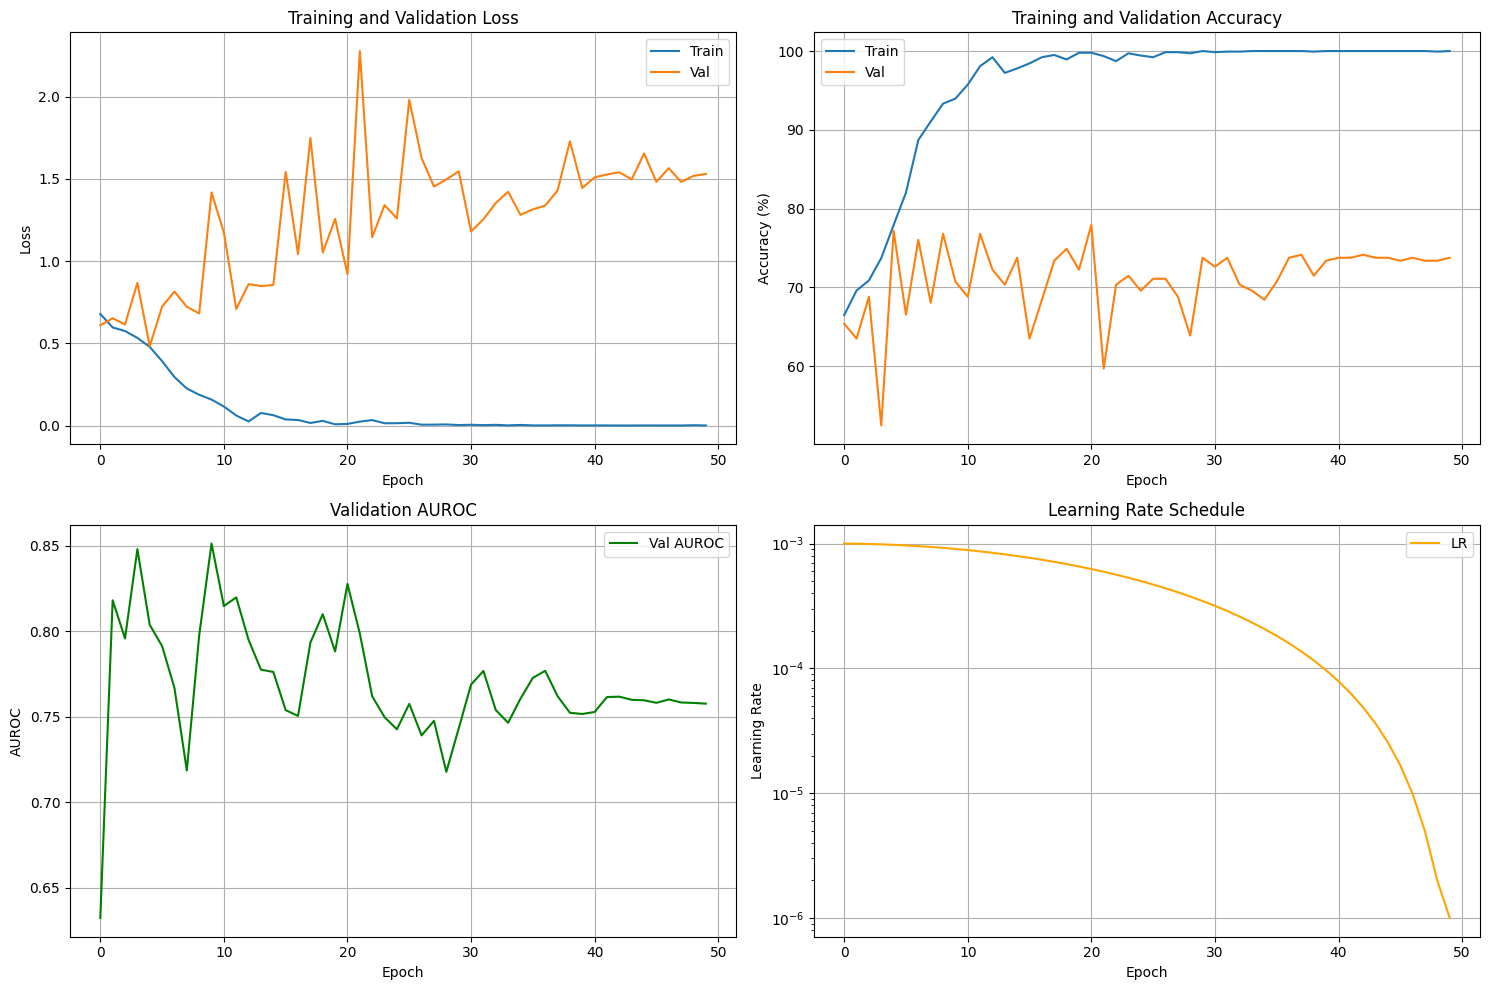

In [8]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train')
axes[0, 1].plot(history['val_acc'], label='Val')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUROC
axes[1, 0].plot(history['val_auroc'], label='Val AUROC', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUROC')
axes[1, 0].set_title('Validation AUROC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate
axes[1, 1].plot(history['lr'], label='LR', color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(config['save_dir'], 'training_curves.png'), dpi=150)
plt.show()

## 9. Test on Test Set

In [11]:
# Load best model
best_checkpoint_path = os.path.join(config['save_dir'], 'checkpoint_best.pth')
if os.path.exists(best_checkpoint_path):
    print(f'Loading best model from {best_checkpoint_path}')
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    print(f'Best model loaded (Val Acc: {checkpoint["best_val_acc"]:.2f}%, AUROC: {checkpoint["best_val_auroc"]:.4f}, F1: {best_val_f1:.4f})')
else:
    print('Best checkpoint not found, using current model')

# Test
print('\nEvaluating on test set...')
test_loss, test_acc, test_auroc, test_f1 = validate(model, test_loader, criterion, device, 'Test')

print('\n' + '=' * 80)
print('Test Results:')
print(f'  Loss: {test_loss:.4f}')
print(f'  Accuracy: {test_acc:.2f}%')
print(f'  AUROC: {test_auroc:.4f}')
print(f'  F1 Score: {test_f1:.4f}')
print('=' * 80)

Loading best model from ./checkpoints/resnet3d_mci_cn/checkpoint_best.pth
Best model loaded (Val Acc: 77.95%, AUROC: 0.8276)

Evaluating on test set...


[Test]: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, loss=0.1010, acc=73.63%]


Test Results:
  Loss: 1.5163
  Accuracy: 73.63%
  AUROC: 0.7332
  F1 Score: 0.5600


## 10. Test on OOD (Out-of-Distribution) Dataset

In [ ]:
# Test on OOD dataset if enabled
if config.get('test_ood', False):
    print('\n' + '=' * 80)
    print('Testing on OOD (Out-of-Distribution) Dataset')
    print('=' * 80)
    
    # Create args for OOD dataset
    ood_args = Args()
    ood_args.data_set = 'AD_CN_ood'
    ood_args.data_path = config['ood_data_path']
    
    # Build OOD dataset
    print('Loading OOD dataset...')
    dataset_ood, _ = build_dataset(is_train=False, test_mode=True, args=ood_args)
    print(f'OOD samples: {len(dataset_ood)}')
    
    # Create OOD data loader
    ood_loader = DataLoader(
        dataset_ood,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True,
        drop_last=False
    )
    
    # Test on OOD dataset
    ood_loss, ood_acc, ood_auroc, ood_f1 = validate(model, ood_loader, criterion, device, 'OOD')
    
    print('\n' + '=' * 80)
    print('OOD Test Results:')
    print(f'  Loss: {ood_loss:.4f}')
    print(f'  Accuracy: {ood_acc:.2f}%')
    print(f'  AUROC: {ood_auroc:.4f}')
    print(f'  F1 Score: {ood_f1:.4f}')
    print('=' * 80)
else:
    print('\nOOD testing is disabled. Set config[\'test_ood\'] = True to enable.')


Testing on OOD (Out-of-Distribution) Dataset
Loading OOD dataset...
Number of the class = 2
OOD samples: 109


[OOD]: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s, loss=2.2940, acc=77.98%] 


OOD Test Results:
  Loss: 1.6984
  Accuracy: 77.98%
  AUROC: 0.6824
